# CS-3240 MACHINE LEARNING - PROJECT - JULIUS ZETTELMEIER


In [ ]:
%config Completer.use_jedi = False  # enable code auto-completion
import numpy as np    # library for numerical computations (vectors, matrices, tensors)
import pandas as pd    # library for data manipulation and analysis
import matplotlib.pyplot as plt # library providing tools for plotting data
import glob #necessairy to import all csv files conveniently
from sklearn.preprocessing import PolynomialFeatures    # function to generate polynomial and interaction features
from sklearn.linear_model import LinearRegression, HuberRegressor    # classes providing Linear Regression with ordinary squared error loss and Huber loss, respectively
from sklearn.metrics import mean_squared_error    # function to calculate mean squared error
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold

# Importing and preparing the Raw data:

In [ ]:
path = r'C:\Users\zette\Documents\CS3240MachineLearning_project\DataSets_workouts'
file_names = glob.glob(path + "/*.csv") # importing all file names as list

index = 1
RAWDATA = pd.DataFrame()

for filename in file_names:
    new_activity = pd.read_csv(filename,header = 0) # importing csv of one activity 
    new_activity['Activity Number'] = index # appending new columnn with activity index
    
    new_activity = new_activity.iloc[1:-2 , :] # removing last, second to last (summary row of the activity -> not required) 
                                               # and first row, for reasons described in the report, La
    
    new_activity['Total Ascent'].replace('--', 0.1, inplace=True) # replacing the '--' strings in altitude with integer of 0.01
                                                                    # 0.1 instead of 0 because of feature construction
    new_activity['Total Ascent'] = new_activity['Total Ascent'].astype(int)
    new_activity['Previous Ascent'] = new_activity['Total Ascent'].shift(1)
    new_activity['Previous Ascent'] = new_activity['Previous Ascent'].fillna(.1)  
    new_activity['Previous Ascent'].replace(0.0, 0.1, inplace=True) # replacing the remaining 0 values with 0.1
    new_activity['Cumulative Ascent'] = new_activity['Total Ascent'].cumsum() # Appending "Cumulative Ascent" column
    new_activity['Cumulative Distance'] = new_activity['Distance'].cumsum() # Appending"Cumulative Distance" column
   

    # Coverting the pace format from min:sec to xx,xx min
    pace_split = new_activity['Avg Pace'].str.split(':', expand = True)
    minutes = pace_split[0].astype(float)
    seconds = pace_split[1].astype(float)/60 # in minutes
    minutes = minutes + seconds
    new_activity['Avg Pace'] = minutes
    
    # Shifting Avg Pace
    new_activity['Cumulative Avg Pace'] = new_activity['Avg Pace'].cumsum()/new_activity['Cumulative Distance']
    new_activity['Previous Avg Pace'] = new_activity['Avg Pace'].shift(1)
    new_activity['Previous Avg Pace'] = new_activity['Previous Avg Pace'].fillna(0.1)
   

    # Cumulatice Avg Heart Rate
    new_activity['Cumulative Avg HR'] = new_activity['Avg HR'].cumsum()/new_activity['Cumulative Distance']

    # Data cleaning
    new_activity.drop(new_activity.loc[new_activity['Avg Pace'] >= 6].index, inplace=True)
    new_activity.drop(new_activity.loc[new_activity['Cumulative Avg Pace'] >= 6.5].index, inplace=True)
    new_activity.drop(new_activity.loc[new_activity['Cumulative Ascent'] >= 80].index, inplace=True)
    new_activity.drop(new_activity.loc[new_activity['Previous Avg Pace'] == 0.1].index, inplace=True)
    RAWDATA =  pd.concat([RAWDATA, new_activity],ignore_index=True); # appending read csv to RAWDATA data frame
       
    index = index+1

df = RAWDATA.drop(['Time', 'Cumulative Time','Distance','Max HR','Total Descent', 'Avg Run Cadence',\
                'Avg Stride Length','Calories','Best Pace','Max Run Cadence','Moving Time','Avg Moving Pace'],axis=1)#
display(df)

# Feature plots

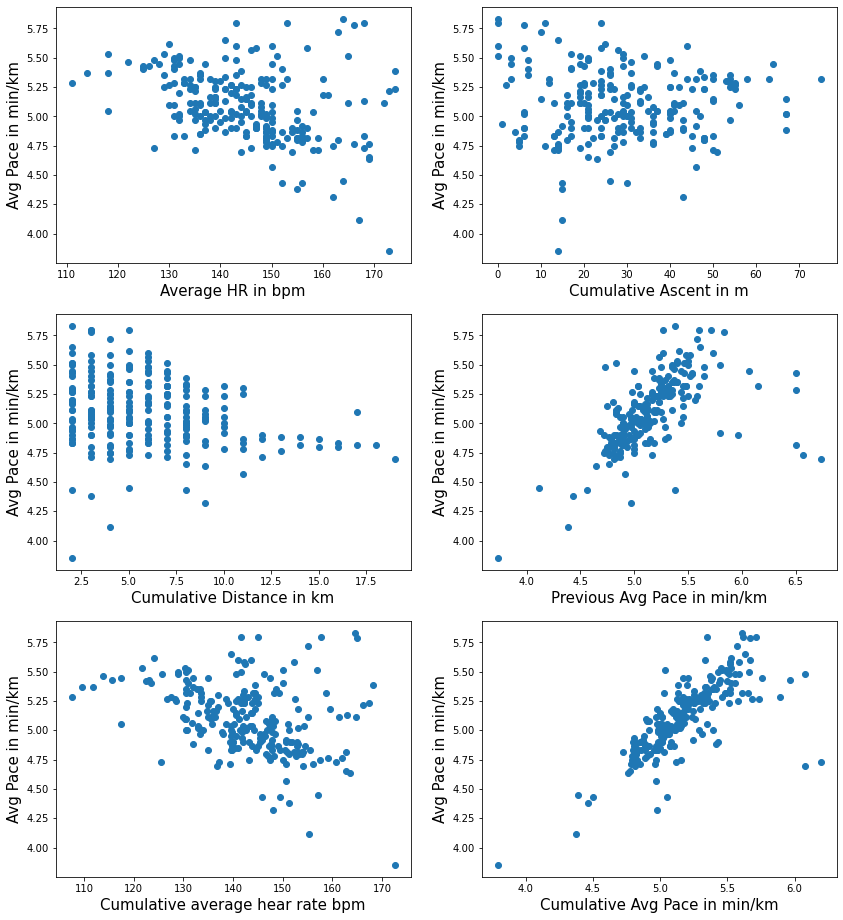

In [3]:
fig, axes = plt.subplots(3, 2, figsize=(14,16)) # create a figure with two axes (1 row,2 columns) on it
axes[0,0].scatter(df['Avg HR'],df['Avg Pace']) # plot a scatter plot on axes[0] to show the relation between MinTemp and MaxTemp
axes[0,0].set_xlabel("Average HR in bpm",size=15)
axes[0,0].set_ylabel("Avg Pace in min/km",size=15)

axes[1,0].scatter(df['Cumulative Distance'],df['Avg Pace']) # plot a scatter plot on axes[0] to show the relation between MinTemp and MaxTemp
axes[1,0].set_xlabel("Cumulative Distance in km",size=15)
axes[1,0].set_ylabel("Avg Pace in min/km",size=15)

axes[1,1].scatter(df['Previous Avg Pace'],df['Avg Pace']) # plot a scatter plot on axes[0] to show the relation between MinTemp and MaxTemp
axes[1,1].set_xlabel("Previous Avg Pace in min/km",size=15)
axes[1,1].set_ylabel("Avg Pace in min/km",size=15)

axes[0,1].scatter(df['Cumulative Ascent'],df['Avg Pace']) # plot a scatter plot on axes[0] to show the relation between MinTemp and MaxTemp
axes[0,1].set_xlabel("Cumulative Ascent in m",size=15)
axes[0,1].set_ylabel("Avg Pace in min/km",size=15)

#axes[2,0].scatter(df['Previous Ascent'],df['Avg Pace']) # plot a scatter plot on axes[0] to show the relation between MinTemp and MaxTemp
#axes[2,0].set_xlabel("Previous Ascent in m",size=15)
#axes[2,0].set_ylabel("Avg Pace in min/km",size=15) 
# not very representative

axes[2,0].scatter(df['Cumulative Avg HR'],df['Avg Pace']) # plot a scatter plot on axes[0] to show the relation between MinTemp and MaxTemp
axes[2,0].set_xlabel("Cumulative average hear rate bpm",size=15)
axes[2,0].set_ylabel("Avg Pace in min/km",size=15)

axes[2,1].scatter(df['Cumulative Avg Pace'],df['Avg Pace']) # plot a scatter plot on axes[0] to show the relation between MinTemp and MaxTemp
axes[2,1].set_xlabel("Cumulative Avg Pace in min/km",size=15)
axes[2,1].set_ylabel("Avg Pace in min/km",size=15)

plt.show()

# Feature Engineering


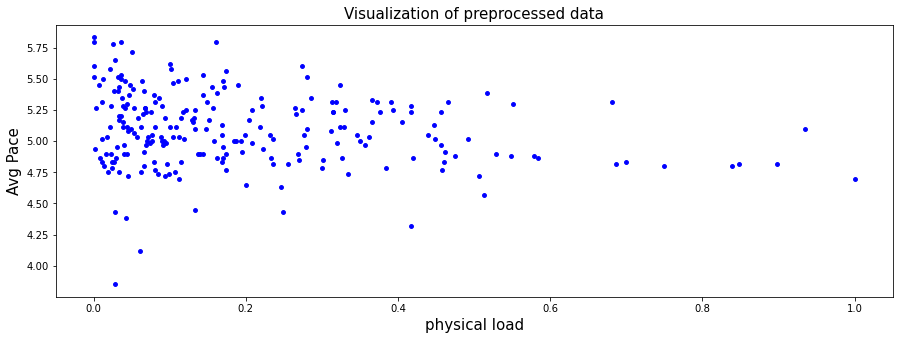

In [4]:
# X equals "physical load"
avg_hr = df['Avg HR'].to_numpy().reshape(-1,1)
cum_asc = df['Cumulative Ascent'].to_numpy().reshape(-1,1)
cum_dist = df['Cumulative Distance'].to_numpy().reshape(-1,1)
prev_avg_pace = df['Previous Avg Pace'].to_numpy().reshape(-1,1)
# prev_asc = df['Previous Ascent'].to_numpy().reshape(-1,1) Not representative -> Chosen to be left out: Messes up the data
cum_avg_hr = df['Cumulative Avg HR'].to_numpy().reshape(-1,1)
cum_avg_pace = df['Cumulative Avg Pace'].to_numpy().reshape(-1,1)

X = np.multiply(avg_hr,cum_asc)
X = np.multiply(X,cum_dist)
X = np.multiply(X,cum_avg_pace)
X = np.multiply(X,cum_avg_hr)

X_min = X.min()
X_max = X.max()
X = (X-X_min)/(X_max-X_min) # normalizing to a area between 0 and 1 -> physical load can be interpreted as a percentage 

y = df['Avg Pace'].to_numpy()

plt.figure(figsize=(15, 5))    # create a new figure with size 8*6
plt.scatter(X, y, color='b', s=15, label='datapoints')
plt.xlabel('physical load',size=15)
plt.ylabel('Avg Pace',size=15)
plt.title('Visualization of preprocessed data',size=15) 

plt.show()

# Splitting Dataset into test, train and validate set

In [5]:
X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.2, random_state=42)

# Polynomial Model without regression

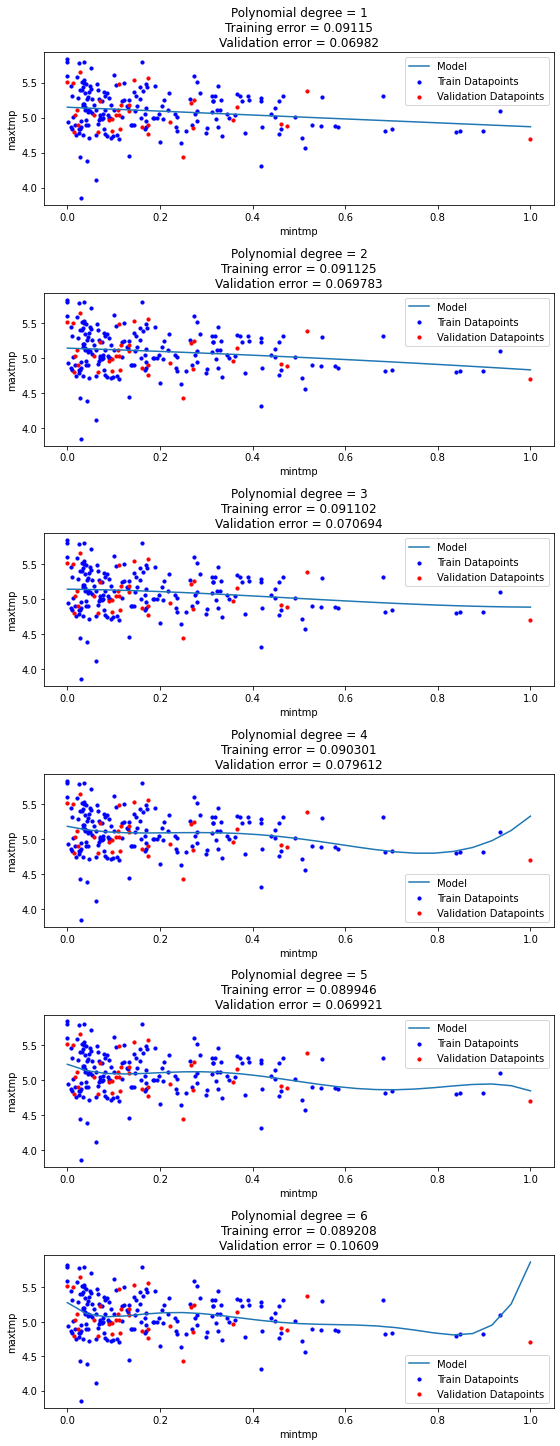

In [6]:
## define a list of values for the maximum polynomial degree 
degrees = [1, 2, 3 , 4 , 5, 6]    

# we will use this variable to store the resulting training errors for each polynomial degree
tr_errors = []          
val_errors = []

plt.figure(figsize=(8, 20))    # create a new figure with size 8*20
for i, degree in enumerate(degrees):    # use for-loop to fit polynomial regression models with different degrees
    plt.subplot(len(degrees), 1, i + 1)    # choose the subplot
    
    lin_regr = LinearRegression(fit_intercept=False) # NOTE: "fit_intercept=False" as we already have a constant iterm in the new feature X_poly
 
    poly = PolynomialFeatures(degree=degree)    # generate polynomial features
    X_train_poly = poly.fit_transform(X_train)    # fit and transform the raw features
    lin_regr.fit(X_train_poly, y_train)    # apply linear regression to these new features and labels
    
    y_pred_train = lin_regr.predict(X_train_poly)
    tr_error = mean_squared_error(y_train,y_pred_train)
    
    X_val_poly = poly.fit_transform(X_val)
    y_pred_val = lin_regr.predict(X_val_poly)
    val_error = mean_squared_error(y_val,y_pred_val)
    
    tr_errors.append(tr_error)
    val_errors.append(val_error)
    X_fit = np.linspace(0, 1, 25)    # generate samples
    plt.tight_layout()
    plt.plot(X_fit, lin_regr.predict(poly.transform(X_fit.reshape(-1, 1))), label="Model")    # plot the polynomial regression model
    plt.scatter(X_train, y_train, color="b", s=10, label="Train Datapoints")    # plot a scatter plot of y(maxtmp) vs. X(mintmp) with color 'blue' and size '10'
    plt.scatter(X_val, y_val, color="r", s=10, label="Validation Datapoints")    # do the same for validation data with color 'red'
    plt.xlabel('mintmp')    # set the label for the x/y-axis
    plt.ylabel('maxtmp')
    plt.legend(loc="best")    # set the location of the legend
    plt.title(f'Polynomial degree = {degree}\nTraining error = {tr_error:.5}\nValidation error = {val_error:.5}')    # set the title
plt.show()    # show the plot

# Validation without Regression


C:\Users\zette\AppData\Local\Temp/ipykernel_4608/1447342087.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.arange(0, 8, step=1))


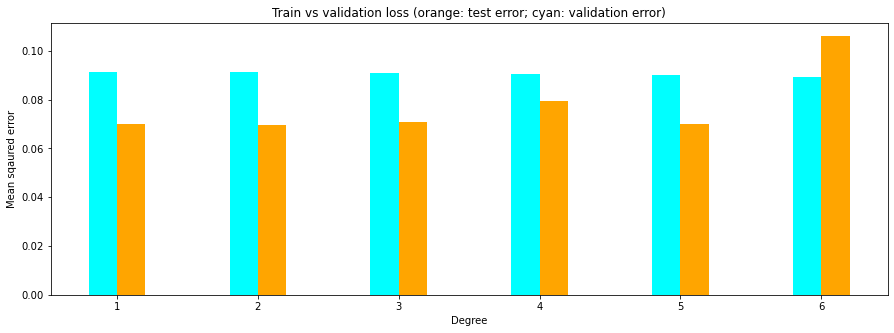

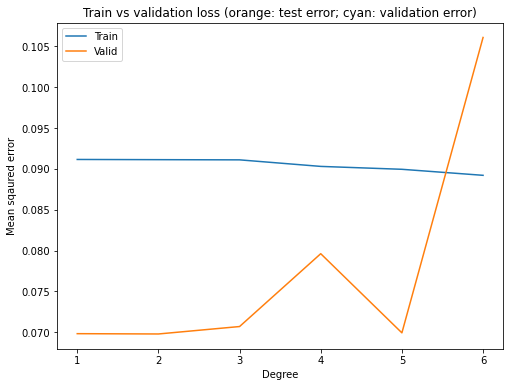

In [7]:
plt.figure(figsize=(15, 5))    # create a new figure with size 8*6
width = 0.2
ax = plt.axes()

degrees_plot_ob = list(np.asarray(degrees) + 0.1)

degrees_plot_ub = list(np.asarray(degrees) - 0.1)

plt.bar(degrees_plot_ub, tr_errors, width, color='cyan')
plt.bar(degrees_plot_ob, val_errors, width, color='orange')
ax.set_xticklabels(np.arange(0, 8, step=1))
plt.xlabel('Degree')
plt.ylabel('Mean sqaured error')
plt.title('Train vs validation loss (orange: test error; cyan: validation error)')
plt.show()

plt.figure(figsize=(8, 6))

plt.plot(degrees, tr_errors, label = 'Train')
plt.plot(degrees, val_errors,label = 'Valid')
plt.legend(loc = 'upper left')

plt.xlabel('Degree')
plt.ylabel('Loss')
plt.ylabel('Mean sqaured error')
plt.title('Train vs validation loss (orange: test error; cyan: validation error)')
plt.show()

# K-fold CV

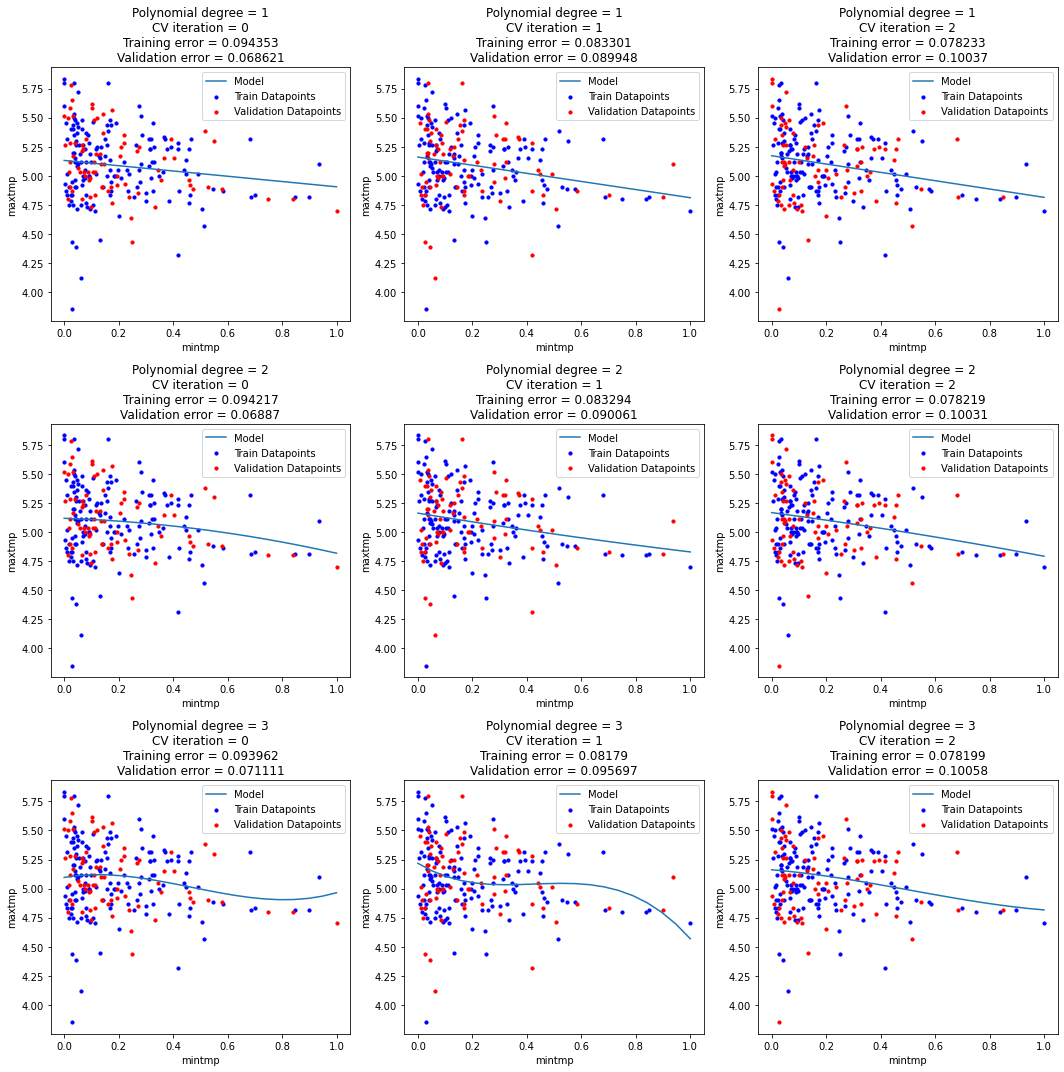

In [14]:
degrees = [1, 2, 3]  
k, shuffle, seed = 3, True, 42
kfold = KFold(n_splits=k, shuffle=shuffle, random_state=seed)

tr_errors = {}          
val_errors = {}

plt.figure(figsize=(15, 15))    # create figure
for i, degree in enumerate(degrees):    # using for-loop to fit polynomial regression models with different degrees
    tr_errors[degree] = [] # k different errors per degree
    val_errors[degree] = []
    
    # for k iterations of training and evaluation
    for j, (train_indices, val_indices) in enumerate(kfold.split(X)): 
        plt.subplot(len(degrees), k, i * k + j + 1)   # choose the subplot

        # Define the training and validation data using the indices returned by kfold and numpy indexing 
        
        X_train, y_train, X_val, y_val = X[train_indices], y[train_indices], X[val_indices], y[val_indices]
        
        lin_regr = LinearRegression(fit_intercept=False)
        poly = PolynomialFeatures(degree=degree)    # generating polynomial features
        X_train_poly = poly.fit_transform(X_train)    # fitting the raw features
        lin_regr.fit(X_train_poly, y_train)    # apply linear regression to these new features and labels

        # Errors on train and validation data obtained from kfold:
        y_pred_train = lin_regr.predict(X_train_poly)    # prediction
        tr_error = mean_squared_error(y_train, y_pred_train)    # training error
        X_val_poly = poly.transform(X_val) # Raw features for the validation data
        y_pred_val = lin_regr.predict(X_val_poly) # Predicting labels for the validation data using the linear model 
        val_error = mean_squared_error(y_val, y_pred_val) # Calculating the validation error
        
        tr_errors[degree].append(tr_error)
        val_errors[degree].append(val_error)
        X_fit = np.linspace(0, 1, 20)    # generating samples
        plt.tight_layout()
        plt.plot(X_fit, lin_regr.predict(poly.transform(X_fit.reshape(-1, 1))), label="Model")    # ploting the polynomial regression model
        plt.scatter(X_train, y_train, color="b", s=10, label="Train Datapoints")   
        plt.scatter(X_val, y_val, color="r", s=10, label="Validation Datapoints")
        plt.xlabel('mintmp')
        plt.ylabel('maxtmp')
        plt.legend(loc="best")
        plt.title(f'Polynomial degree = {degree}\nCV iteration = {j}\nTraining error = {tr_error:.5}\nValidation error = {val_error:.5}')    # set the title


plt.show()


# Average Errors K-Fold CV

Degree 1, avg train error = 0.08530, avg val error = 0.08631
Degree 2, avg train error = 0.08524, avg val error = 0.08641
Degree 3, avg train error = 0.08465, avg val error = 0.08913
(0.0852958022446284, 0.08524341854861779, 0.08465011043352307)


C:\Users\zette\AppData\Local\Temp/ipykernel_4608/3375268537.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.arange(0, 8, step=1))


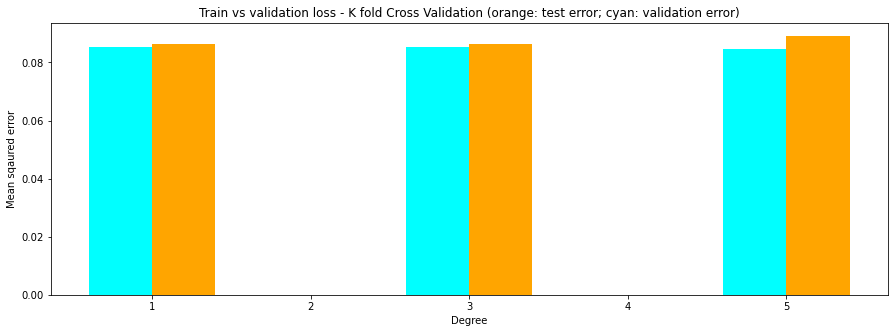

In [15]:
average_train_error, average_val_error = {}, {}

for degree in degrees:
    average_train_error[degree] = np.mean(tr_errors[degree])
    average_val_error[degree] = np.mean(val_errors[degree])
        
    print(f"Degree {degree}, avg train error = {average_train_error[degree]:.5f}, "
          f"avg val error = {average_val_error[degree]:.5f}")

average_train_error = average_train_error.items()
average_val_error = average_val_error.items()

d, average_train_error = zip(*average_train_error)
d, average_val_error = zip(*average_val_error)

plt.figure(figsize=(15, 5)) 
width = 0.2
ax = plt.axes()

degrees_plot_ob = list(np.asarray(degrees) + 0.1)
degrees_plot_ub = list(np.asarray(degrees) - 0.1)

print(average_train_error)
plt.bar(degrees_plot_ub, average_train_error, width, color='cyan')
plt.bar(degrees_plot_ob, average_val_error, width, color='orange')
ax.set_xticklabels(np.arange(0, 8, step=1))
plt.xlabel('Degree')
plt.ylabel('Mean sqaured error')
plt.title('Train vs validation loss - K fold Cross Validation (orange: test error; cyan: validation error)')
plt.show()

# Function for Model with Regularization

In [16]:
def train_validate_poly(X_train, y_train, X_val, y_val, model=LinearRegression, degree=2):
    # train a polynomial model and validate it

    # generate polynomial features
    poly_features = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly_features.fit_transform(X_train)
    X_val_poly = poly_features.transform(X_val)

    # learn the model and validate it
    reg = model()
    reg = reg.fit(X_train_poly, y_train)
    y_train_pred = reg.predict(X_train_poly)
    y_val_pred = reg.predict(X_val_poly)
    train_err = mean_squared_error(y_train, y_train_pred)
    val_err = mean_squared_error(y_val, y_val_pred)
    return reg, train_err, val_err


# Investigating Regularization

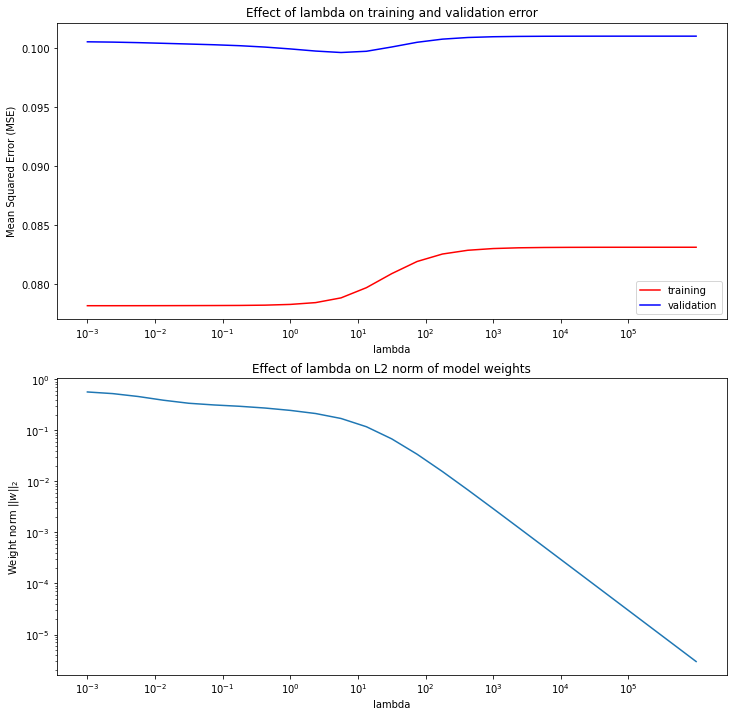

In [17]:
# iteratively try different lambdas
regs = []
train_errs = []
val_errs = []
l_range = (-3, 6)
lambdas = np.logspace(*l_range, num=25)  # candidate lambdas
for l in lambdas:
    reg, train_err, val_err = train_validate_poly(
        X_train, y_train, X_val, y_val, lambda: Ridge(alpha=l, solver='svd'), degree=degree)
    regs.append(reg)
    train_errs.append(train_err)
    val_errs.append(val_err)
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# plot the data
plt.setp(axs, xscale='log', xticks=[10**x for x in range(*l_range)], xlabel='lambda', ylabel='Mean Squared Error (MSE)')
axs[0].plot(lambdas, train_errs, color='red', label='training')
axs[0].plot(lambdas, val_errs, color='blue', label='validation')
axs[0].set_title('Effect of lambda on training and validation error')
axs[0].legend()

axs[1].set_yscale('log')
axs[1].plot(lambdas, [np.linalg.norm(reg.coef_) for reg in regs])
axs[1].set_ylabel('Weight norm $||w||_2$')
axs[1].set_title('Effect of lambda on L2 norm of model weights')
plt.show()